# Pulsar Signal Simulator Tutorial Notebook 2 - Fold Mode

This notebook will build on the first tutorial, showing more features of the PsrSigSim. More detail will be given for new features, and less for features that have been discussed in previous tutorial notebooks. This notebook in particular will show the details of using the fold-mode, or simulation of subintegrated data. This may be useful for simulating pulsar timing style data, as a way to save disk space and computation time. 

The example we use here is for simulating precision pulsar timing data. Instead of simulating the single pulses from a pulsar and then folding them to obtain a high signal-to-noise pulse profiles to use for precision pulsar timing, we can simulate a pre-folded observation.

In [5]:
# import some useful packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import the pulsar signal simulator
#import psrsigsim as pss
from PsrSigSim import psrsigsim as pss

## Setting up the Folded Signal

Here we will again set up the signal class, but this time we will add some additional flags, namely the `fold`, `sample_rate`, and `sublen` flags. Setting `fold=True` tells the simulator that we want to simulate folded data, with subinegration lengths of `sublen=X` where `X` is some number of seconds. We will set the sample rate such that we will simulate 2048 samples across the pulse period (we will use a pulse period of 10 ms for this simulation). 

We will simulate a 20 minute long observation total, with subintegrations of 1 minute. The other simulation parameters will be 64 frequency channels each 12.5 MHz wide (for 800 MHz bandwidth) observed with the Green Bank Telescope at L-band (1500 MHz center frequency). 

In [7]:
# Define our signal variables.
f0 = 1500 # center observing frequecy in MHz
bw = 800.0 # observation MHz
Nf = 64 # number of frequency channels
# We define the pulse period early here so we can similarly define the frequency
period = 0.010 # pulsar period in seconds
f_samp = (1.0/period)*2048*10**-6 # sample rate of data in MHz (here 2048 samples across the pulse period
sublen = 60.0 # subintegration length in seconds, or rate to dump data at
# Now we define our signal
signal_fold = pss.signal.FilterBankSignal(fcent = f0, bandwidth = bw, Nsubband=Nf, sample_rate = f_samp,
                                       sublen = sublen, fold = True) # fold is set to `True`

## The Pulsar

Here we set up the `Pulsar` the same way as in the previous tutorial. We will again use a basic Gaussian profile, but will have a more realisitic mean flux of 5 mJy (or 0.005 Jy).

In [8]:
# We define the Guassian profile
gauss_prof = pss.pulsar.GaussProfile(peak = 0.5, width = 0.05, amp = 1.0)

In [9]:
# Define the values needed for the puslar
Smean = 0.005 # The mean flux of the pulsar, here 0.005 Jy
psr_name = "J0000+0000" # The name of our simulated pulsar
# Now we define the pulsar
pulsar_fold = pss.pulsar.Pulsar(period, Smean, profiles=gauss_prof, name = psr_name)

## The ISM

We similarly set up the interstellar medium (ISM) object as before.

In [12]:
# Define the dispersion measure
dm = 40.0 # pc cm^-3
# And define the ISM object, note that this class takes no initial arguements
ism_fold = pss.ism.ISM()

## The Telescope

Again, we will use the default Green Bank Telescope as our observing telescope.

In [13]:
tscope = pss.telescope.telescope.GBT()

## Simulating the Signal

Now we will simulate the signal. Here the commands are the same as before, we just need to define an observation length (20 minutes), make the pulses with the pulsar, disperse the data, And then observe the pulsar with our telescope. For the telescope, we will use the `Lband_GUPPI` system predefined by in the GBT telescope class.

In [14]:
# define the observation length
obslen = 60.0*20 # seconds, 20 minutes in total

In [15]:
# Make the pulses
pulsar_fold.make_pulses(signal_fold, tobs = obslen)

In [16]:
# Disperse the data
ism_fold.disperse(signal_fold, dm)

98% dispersed in 0.145 seconds.

In [17]:
# Observe with the telescope
tscope.observe(signal_fold, pulsar_fold, system="Lband_GUPPI", noise=True)

## Visualizing the Data

Now that we've simuluated the signal, we can take a look at the subintegrated data that we have produced. We can access it the same way as described in the previous tutorial.

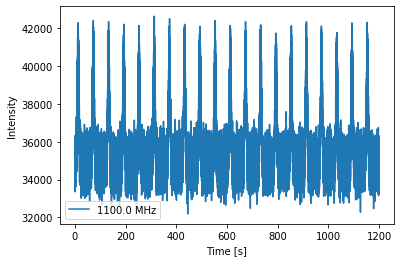

In [19]:
# Get the phases of the pulse
time = np.linspace(0, obslen, len(signal_fold.data[0,:]))
# Plot just the pulses in the first frequency channels
plt.plot(time, signal_fold.data[0,:], label = signal_fold.dat_freq[0])
plt.ylabel("Intensity")
plt.xlabel("Time [s]")
plt.legend(loc = 'best')
plt.show()
plt.close()

If we zoom in on just the first two pulse periods...

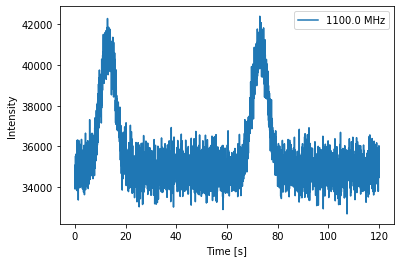

In [20]:
# Since we know there are 2048 bins per pulse period, we can index the appropriate amount
plt.plot(time[:4096], signal_fold.data[0,:4096], label = signal_fold.dat_freq[0])
plt.ylabel("Intensity")
plt.xlabel("Time [s]")
plt.legend(loc = 'best')
plt.show()
plt.close()

We can clearly see the pulse profile above the noise level now. By making subintegrated data, we build up the signal of the simulated pulses to be easily visible. With a 10 ms period and 1 minute subintegrations, each of these pulses acts as if we have folded (1 minutes / 10 ms) = 6000 pulses together. We can look at the 2D spectrogram of these pulses as well.

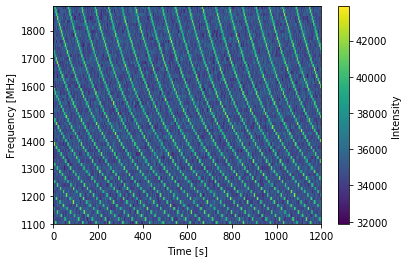

In [21]:
# Make the 2-D plot of intensity v. frequency and pulse phase. You can see the slight dispersive sweep here.
plt.imshow(signal_fold.data, aspect = 'auto', interpolation='nearest', origin = 'lower', \
           extent = [min(time), max(time), signal_fold.dat_freq[0].value, signal_fold.dat_freq[-1].value])
plt.ylabel("Frequency [MHz]")
plt.xlabel("Time [s]")
plt.colorbar(label = "Intensity")
plt.show()
plt.close()

The pulse and dispersive sweep is clearly visible with the high signal-to-noise ratio. Again, zooming in on the first two subintegrations...

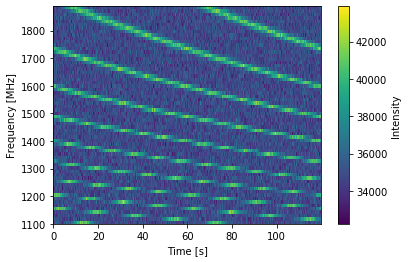

In [22]:
plt.imshow(signal_fold.data[:,:4096], aspect = 'auto', interpolation='nearest', origin = 'lower', \
           extent = [min(time[:4096]), max(time[:4096]), signal_fold.dat_freq[0].value, signal_fold.dat_freq[-1].value])
plt.ylabel("Frequency [MHz]")
plt.xlabel("Time [s]")
plt.colorbar(label = "Intensity")
plt.show()
plt.close()

Here the dispersion clearly shows that the pulses are dispersed for over two minutes across the observing bandwidth.